# Import Packages

In [1]:
# Import packages
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
logs_df = pd.read_csv("../Data Cleaning/cleaned_dataset.csv")
logs_df

,SEX,AGE,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD_BERNOULLI,REWARD_CATEGORICAL,REWARD_VALUE (BER),REWARD_VALUE (CAT)
0,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,1
1,F,YOUNG,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,3
2,F,YOUNG,Y,N,N,N,N,N,3,Alive,Alive and recovered,1,4
3,F,OLD,N,L,Y,NaN,NaN,L,2,Dead,Dead,0,1
4,M,OLD,N,N,N,Y,N,N,1,Alive,Alive and still dependent,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,F,YOUNG,N,N,N,N,N,N,1,Alive,Alive and recovered,1,4
2496,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,1
2497,M,OLD,N,N,Y,NaN,NaN,N,1,Dead,Dead,0,1
2498,M,YOUNG,N,N,N,N,N,N,1,Alive,Alive and recovered,1,4


In [3]:
# Generate a list of 2500 tuples of gender and age values
# AGE: OLD = 1, YOUNG = 0
logs_df.loc[logs_df['AGE'] == 'OLD', 'AGE_new'] = 1
logs_df.loc[logs_df['AGE'] == 'YOUNG', 'AGE_new'] = 0
logs_df["AGE_new"] = logs_df["AGE_new"].astype(int)
# GENDER: M = 1, F = 0
logs_df.loc[logs_df['SEX'] == 'M', 'SEX_new'] = 1
logs_df.loc[logs_df['SEX'] == 'F', 'SEX_new'] = 0
logs_df["SEX_new"] = logs_df["SEX_new"].astype(int)

gender_list = logs_df['SEX_new'].to_numpy()
age_list = logs_df['AGE_new'].to_numpy()

gender_age_list = list(zip(gender_list, age_list))
gender_age_list = np.array(gender_age_list)
gender_age_list


array([[1, 1],
       [0, 0],
       [0, 0],
       ...,
       [1, 1],
       [1, 0],
       [1, 0]])

# Algorithms

In [4]:
class LinUCB:
    def __init__(self, n_arms, n_features, alpha):
        self.n_arms = n_arms
        self.n_features = n_features
        self.alpha = alpha
        self.A = [np.identity(n_features) for _ in range(n_arms)]
        self.b = [np.zeros(n_features) for _ in range(n_arms)]

    def update(self, arm, x_t, reward):
        self.A[arm] += np.outer(x_t, x_t)
        self.b[arm] += reward * x_t

    def recommend(self, x_t):
        scores = np.zeros(self.n_arms)
        thetas = [np.zeros(self.n_features) for _ in range(self.n_arms)]
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])
            theta = A_inv @ self.b[arm]
            p_arm = theta.T @ x_t + self.alpha * np.sqrt(x_t.T @ A_inv @ x_t)
            scores[arm] = p_arm
            thetas[arm] = theta
        return np.argmax(scores), thetas, scores

In [5]:
class LinThompsonSampling:
    def __init__(self, n_arms, n_features, alpha):
        self.n_arms = n_arms
        self.n_features = n_features
        self.B = [np.identity(n_features) for _ in range(n_arms)] 
        self.mu_hat = [np.zeros(n_features) for _ in range(n_arms)]
        self.f = [np.zeros(n_features) for _ in range(n_arms)]
        self.alpha = alpha
        # self.v = R * np.sqrt(24 / epsilon * n_features * np.log(1 / delta))

    def update(self, arm, x_t, reward):
        self.B[arm] += x_t.dot(x_t.T)
        self.f[arm] += reward*x_t
        self.mu_hat[arm] = np.linalg.inv(self.B[arm]).dot(self.f[arm])

    def recommend(self, x_t):
        scores = np.zeros(self.n_arms)
        thetas = [np.zeros(self.n_features) for _ in range(self.n_arms)]
        for arm in range(self.n_arms):
            mu_tilde = np.random.multivariate_normal(self.mu_hat[arm].flat, self.alpha**2 * np.linalg.inv(self.B[arm]))[..., np.newaxis]
            # theta = 1/(1+np.exp(-1 * self.f[arm]))
            theta = 1/(1+np.exp(-1 * self.B[arm].dot(self.mu_hat[arm])))
            scores[arm] = x_t.dot(mu_tilde)
            thetas[arm] = theta
        return np.argmax(scores), thetas, scores

# Simulation and Tuning

In [6]:
def simulate_one_time_reward(arm, x_t, theta, scale_noise = 0.01):
    signal = theta @ x_t
    noise  = np.random.normal(scale = scale_noise) 
    return (signal + noise)

In [7]:
# Implement Simulation Test
def test_algorithm(algo, n_arms, n_features, n_sims, n_steps, alpha, gender_age_list):
    chosen_arms = [0 for i in range(n_sims * n_steps)]
    rewards = [0 for i in range(n_sims * n_steps)]
    cumulative_rewards = [0 for i in range(n_sims * n_steps)]
    sim_rounds = [0 for i in range(n_sims * n_steps)]
    time_steps = [0 for i in range(n_sims * n_steps)]
    
    for sim in range(n_sims):
        sim = sim + 1
        
        for t in range(n_steps):
            x_t = gender_age_list[t]
            t = t + 1
            index = (sim-1) * n_steps + t - 1
            sim_rounds[index] = sim
            time_steps[index] = t
            
            chosen_arm, thetas, scores = algo.recommend(x_t)
            chosen_arms[index] = chosen_arm
            
            theta = thetas[chosen_arm]
            
            reward = simulate_one_time_reward(chosen_arm, x_t, theta, scale_noise = 0.01)
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward 
            
            algo.update(chosen_arm, x_t, reward)

    return (sim_rounds, time_steps, chosen_arms, rewards, cumulative_rewards)

## LinUCB

In [8]:
n_steps = gender_age_list.shape[0]
n_sims = 100
alpha_values = [0.1, 0.5, 1, 5, 10]
num_features = 2
num_arms = 4
all_results_linUCB = pd.DataFrame(columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"])

In [9]:
for alpha in alpha_values:
    linUCB_algo = LinUCB(num_arms, num_features, alpha)
    results_linUCB = pd.DataFrame(test_algorithm(linUCB_algo, num_arms, num_features, 
                                                  n_sims, n_steps, alpha, gender_age_list)).transpose()
    results_linUCB.columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"]
    results_linUCB["alpha"] = alpha
    all_results_linUCB = pd.concat([all_results_linUCB, results_linUCB])

In [10]:
all_results_linUCB["n_sim"] = all_results_linUCB["n_sim"].astype(int)
all_results_linUCB["n_step"] = all_results_linUCB["n_step"].astype(int)
all_results_linUCB["chosen_treatment"] = all_results_linUCB["chosen_treatment"].astype(int)
all_results_linUCB = all_results_linUCB.reset_index(drop = True)

In [11]:
all_results_linUCB

,n_sim,n_step,chosen_treatment,rewards,cumulative_rewards,alpha
0,1,1,0,-0.009987,-0.009987,0.1
1,1,2,0,-0.005193,-0.015181,0.1
2,1,3,0,0.015038,-0.000143,0.1
3,1,4,1,-0.008005,-0.008148,0.1
4,1,5,2,-0.013318,-0.021467,0.1
...,...,...,...,...,...,...
1249995,100,2496,0,-0.009445,-6.027178,10.0
1249996,100,2497,2,-0.013880,-6.041058,10.0
1249997,100,2498,1,-0.021212,-6.062269,10.0
1249998,100,2499,3,0.022930,-6.039340,10.0


In [12]:
# If chosen_treatment = to the treatment with highest click_probability, return 1 else 0
success_probabilities_linUCB = [0.6, 0.4, 0.8, 0.9]

all_results_linUCB['if_best_treatment'] = np.where(all_results_linUCB['chosen_treatment'] == success_probabilities_linUCB.index(max(success_probabilities_linUCB)), 1, 0)

# Group by epsilon and n_step
results_plot_linUCB = all_results_linUCB.groupby(['alpha', 'n_step'], as_index = False).aggregate({'if_best_treatment': lambda x: x.sum() / float(x.count()), "rewards":"mean", "cumulative_rewards":"mean"})

In [13]:
results_plot_linUCB

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
0,0.1,1,0.98,0.005216,0.005216
1,0.1,2,0.00,-0.000756,0.004460
2,0.1,3,0.00,0.000290,0.004750
3,0.1,4,0.98,0.014038,0.018788
4,0.1,5,0.97,0.007108,0.025896
...,...,...,...,...,...
12495,10.0,2496,0.00,0.000176,-8.111133
12496,10.0,2497,0.31,-0.008317,-8.119450
12497,10.0,2498,0.29,-0.007945,-8.127395
12498,10.0,2499,0.39,0.001319,-8.126077


### Rewards

Text(0.5, 1.0, 'The probability of choosing the best treatment')

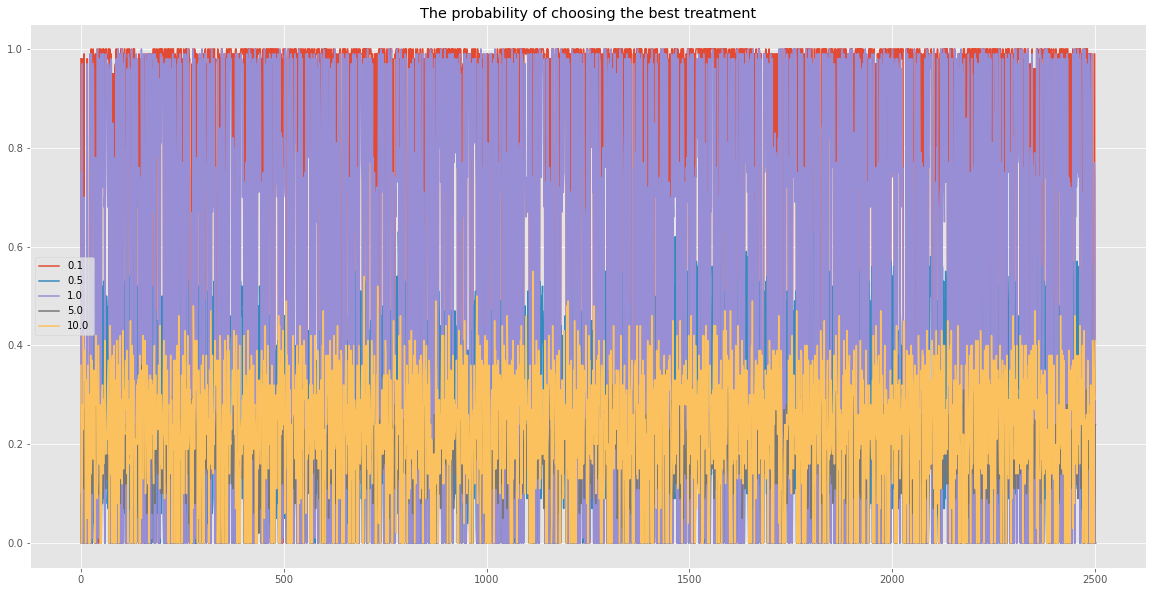

In [14]:
plt.style.use('ggplot')

# Plot the probability of choosing the best movie
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['if_best_treatment'], label = str(alpha))

plt.legend() 
plt.title("The probability of choosing the best treatment")

Text(0.5, 1.0, 'Average rewards at each time step')

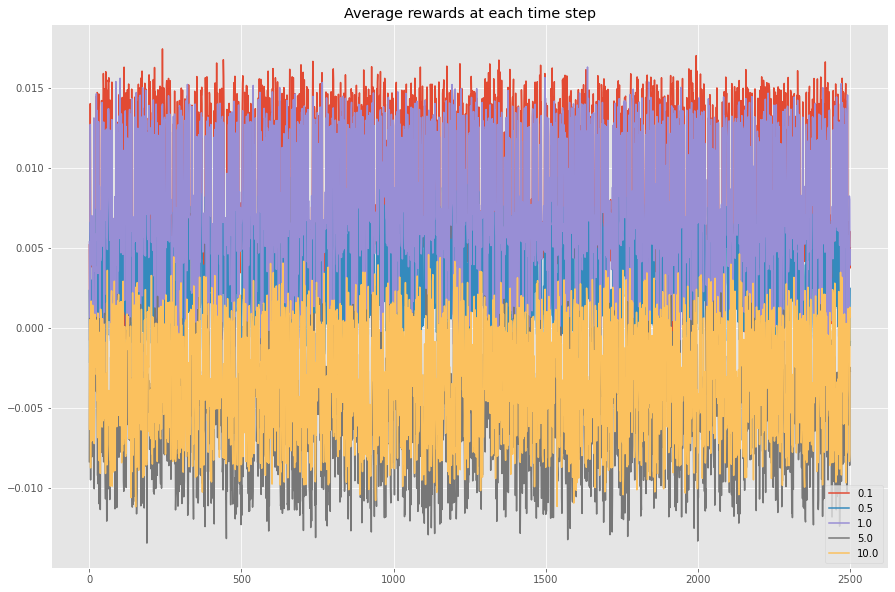

In [15]:
# plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['rewards'], label = str(alpha))

plt.legend()
plt.title("Average rewards at each time step")

In [16]:
# Determine the cumulative reward at 1000 time step
results_plot_linUCB[results_plot_linUCB["n_step"] == 2500].sort_values(by=["cumulative_rewards"], ascending = False)

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
2499,0.1,2500,0.00,0.005025,19.208671
7499,1.0,2500,0.00,0.004909,18.970711
4999,0.5,2500,0.00,-0.000835,7.235981
12499,10.0,2500,0.41,0.000706,-8.125370
9999,5.0,2500,0.24,-0.002681,-13.522448


Text(0.5, 1.0, 'Cumulative rewards at each step')

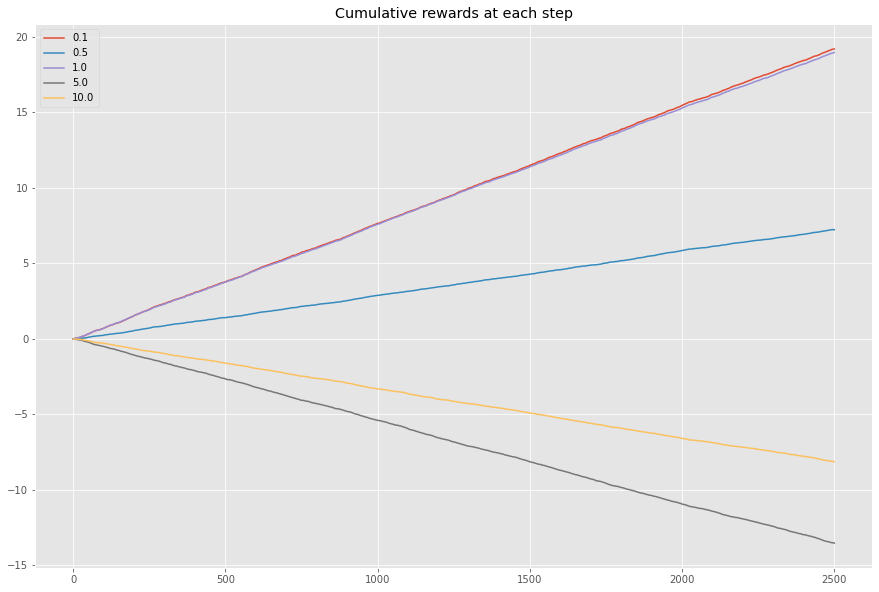

In [17]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
    
for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['cumulative_rewards'], label = str(alpha))

plt.legend()
plt.title("Cumulative rewards at each step")

## Lin Thompson Sampling

In [18]:
all_results_linTS = pd.DataFrame(columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"])
R_values = [0.01, 0.1]
epsilon_values = [0.1, 0.5, 0.9]
delta = 0.5
# alpha_values = [0.1, 1, 10, 100, 1000]
alpha_values = []

for R in R_values:
    for epsilon in epsilon_values:
        alpha_value = R * np.sqrt(24 / epsilon * num_features * np.log(1 / delta))
        alpha_values.append(alpha_value)

In [19]:
for alpha in alpha_values:
    linTS_algo = LinThompsonSampling(num_arms, num_features, alpha)
    results_linTS = pd.DataFrame(test_algorithm(linTS_algo, num_arms, num_features, 
                                                n_sims, n_steps, alpha, gender_age_list)).transpose()
    results_linTS.columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"]
    results_linTS["alpha"] = alpha
    all_results_linTS = pd.concat([all_results_linTS, results_linTS])

In [20]:
all_results_linTS["n_sim"] = all_results_linTS["n_sim"].astype(int)
all_results_linTS["n_step"] = all_results_linTS["n_step"].astype(int)
all_results_linTS["chosen_treatment"] = all_results_linTS["chosen_treatment"].astype(int)
all_results_linTS = all_results_linTS.reset_index(drop = True)

In [21]:
all_results_linTS

,n_sim,n_step,chosen_treatment,rewards,cumulative_rewards,alpha
0,1,1,0,0.998170,0.998170,0.182404
1,1,2,0,0.002316,1.000487,0.182404
2,1,3,0,-0.002926,0.997560,0.182404
3,1,4,1,0.499464,1.497025,0.182404
4,1,5,0,1.467367,2.964392,0.182404
...,...,...,...,...,...,...
1499995,100,2496,0,-0.004675,2891.020424,0.608012
1499996,100,2497,3,2.000514,2893.020937,0.608012
1499997,100,2498,3,1.995686,2895.016624,0.608012
1499998,100,2499,1,0.989857,2896.006481,0.608012


In [22]:
all_results_linTS['if_best_treatment'] = np.where(all_results_linTS['chosen_treatment'] == success_probabilities_linUCB.index(max(success_probabilities_linUCB)), 1, 0)

# Group by n_step
results_plot_linTS = all_results_linTS.groupby(['alpha', 'n_step'], as_index = False).aggregate({'if_best_treatment': lambda x: x.sum() / float(x.count()), "rewards":"mean", "cumulative_rewards":"mean"})

In [23]:
results_plot_linTS

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
0,0.060801,1,0.00,1.991618,1.991618
1,0.060801,2,0.00,-0.000728,1.990890
2,0.060801,3,0.00,0.000705,1.991595
3,0.060801,4,0.00,0.996569,2.988164
4,0.060801,5,0.00,1.996009,4.984173
...,...,...,...,...,...
14995,1.824036,2496,0.00,0.000438,2890.964298
14996,1.824036,2497,0.46,2.001929,2892.966227
14997,1.824036,2498,0.44,2.000153,2894.966380
14998,1.824036,2499,0.00,0.999918,2895.966298


### Rewards

Text(0.5, 1.0, 'The probability of choosing the best treatment')

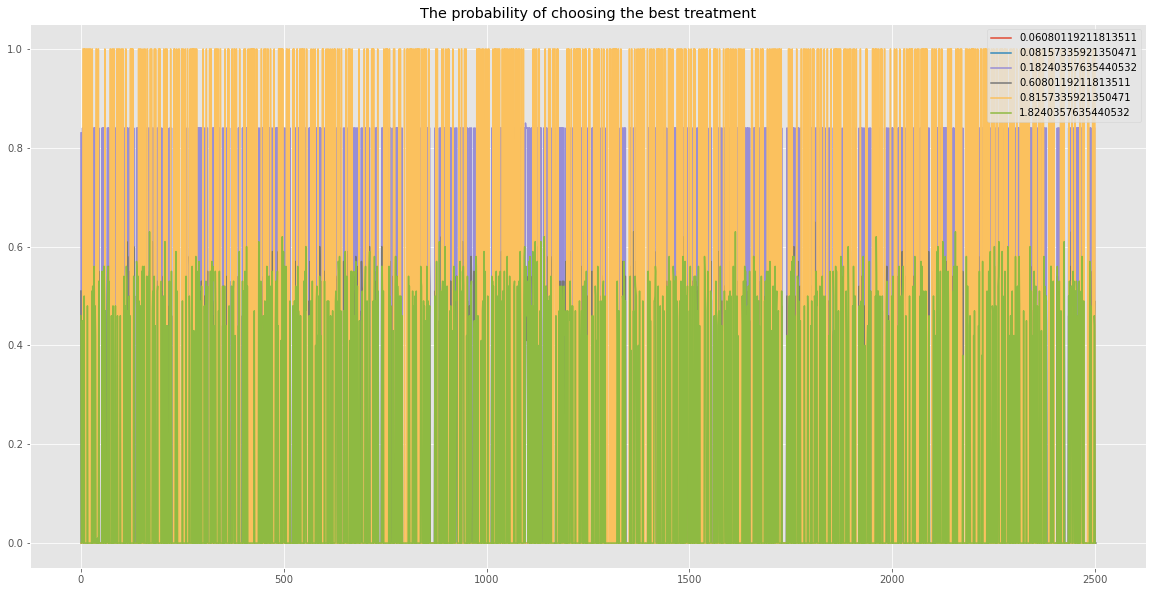

In [24]:
plt.style.use('ggplot')

# Plot the probability of choosing the best treatment
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for alpha in results_plot_linTS['alpha'].unique():
    results_linTS = results_plot_linTS[results_plot_linTS['alpha'] == alpha]
    ax.plot(results_linTS['n_step'], results_linTS['if_best_treatment'], label = str(alpha))

plt.legend() 
plt.title("The probability of choosing the best treatment")

Text(0.5, 1.0, 'Average rewards at each time step')

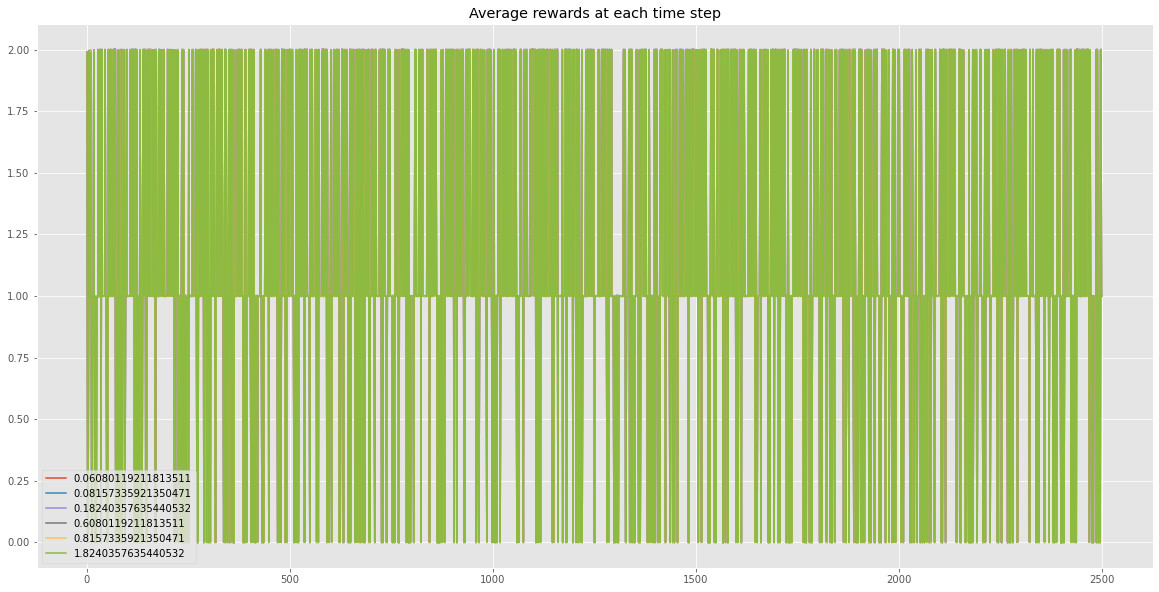

In [25]:
plt.style.use('ggplot')

# Plot the probability of choosing the best treatment
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for alpha in results_plot_linTS['alpha'].unique():
    results_linTS = results_plot_linTS[results_plot_linTS['alpha'] == alpha]
    ax.plot(results_linTS['n_step'], results_linTS['rewards'], label = str(alpha))

plt.legend() 
plt.title("Average rewards at each time step")

In [26]:
# Determine the cumulative reward at 1000 time step
results_plot_linTS[results_plot_linTS["n_step"] == 2500].sort_values(by=["cumulative_rewards"], ascending = False)

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
4999,0.081573,2500,0.0,1.000765,2897.008282
2499,0.060801,2500,0.0,0.998336,2896.991945
14999,1.824036,2500,0.0,1.000131,2896.966429
7499,0.182404,2500,0.0,1.001769,2896.964210
9999,0.608012,2500,0.0,0.999421,2896.900724
12499,0.815734,2500,1.0,1.000624,2896.871288


Text(0.5, 1.0, 'Cumulative rewards at each step')

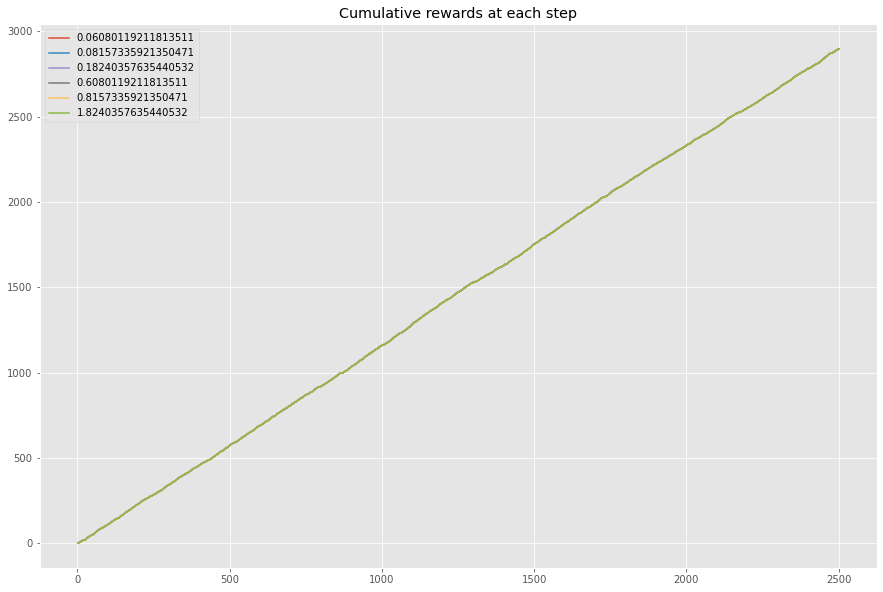

In [27]:
plt.style.use('ggplot')

# Plot the probability of choosing the best treatment
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
for alpha in results_plot_linTS['alpha'].unique():
    results_linTS = results_plot_linTS[results_plot_linTS['alpha'] == alpha]
    ax.plot(results_linTS['n_step'], results_linTS['cumulative_rewards'], label = str(alpha))

plt.legend() 
plt.title("Cumulative rewards at each step")